In [1]:
import heeps
from heeps.wavefront.get_array import show_wf
from heeps.util.psf_template import psf_template
from heeps.util.lamD import get_lamD_mas
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import vip_hci

In [2]:
def get_band_mode(case):
    band_mode = {'ELT-L' :  ('L', 'ELT'),
                 'ELT-N' :  ('N2', 'ELT'),
                 'IMG-LM' : ('L', 'IMG'),
                 'IMG-LM-thick' : ('L', 'IMG'),
                 'APP-LM' : ('L', 'APP'),
                 'SPP-LM' : ('L', 'SPP'),
                 'RLS-LM' : ('L', 'RAVC'),
                 'CLS-LM' : ('L', 'CVC'),
                 'ULS-LM' : ('L', 'CLC'),
                 'IMG-N'  : ('N2', 'IMG'),
                 'IMG-N-thick': ('N2', 'IMG'),
                 'CLS-N'  : ('N2', 'CVC'),
                 'ULS-N'  : ('N2', 'CLC'),
                 'APP-LMS': ('L', 'APP'),
                 'RLS-LMS': ('L', 'RAVC'),
                 'CLS-LMS': ('L', 'CVC'),
                 'ULS-LMS': ('L', 'CLC')}
    return band_mode[case]

def get_margins(case):
    ls_dR = {'ELT-L' :  (0, 0, 0),# no stop at all
             'ELT-N' :  (0, 0, 0),
             'IMG-LM' : (2.09, 2.09, 2.91), # "spider mask"
             'IMG-LM-thick' : (2.09, 2.09, 2.31), # one spider is thicker (AsymPupil)
             'APP-LM' : (2.09, 2.09, 2.91),# load fits file
             'SPP-LM' :  (0, 0, 0), # SPP defines its own stop
             'RLS-LM' : (4.77, 4.00, 2.49),
             'CLS-LM' : (2.09, 9.00, 2.45),
             'ULS-LM' : (10.95, 4.91, 3.17),
             'IMG-N'  : (2.68, 2.68, 3.57), # "spider mask"
             'IMG-N-thick': (2.68, 2.68, 2.97),
             'CLS-N'  : (2.68, 9.00, 3.57),
             'ULS-N'  : (10.45, 5.11, 3.83),
             'APP-LMS': (2.41, 2.41, 3.08),# load fits file
             'RLS-LMS': (4.68, 4.00, 2.80),
             'CLS-LMS': (2.18, 9.00, 2.88),
             'ULS-LMS': (10.95, 4.91, 3.17),
             }
    return np.round(np.array(ls_dR[case])/100, 4)

def get_throughput(case, ELT_aper_flux=None, dRspi_thick=0.0291, spi_width=0.54,
                    diam_nominal=38.542, AP_angles=[0], show_pup=True, verbose=False):
    band, mode = get_band_mode(case)
    ls_dRext, ls_dRint, ls_dRspi = get_margins(case)
    det = 'LMS' if 'LMS' in case else 'IMG'
    f_app_amp = 'optics/app/METIS_%s_L_amp.fits'%det
    f_app_phi = 'optics/app/METIS_%s_L_phase.fits'%det
    f_spp_amp = 'optics/spp/SP_AP2_masked_rot_crop_bin.fits'
    conf = dict(band=band, mode=mode, nframes=1, add_phase=False, 
                f_app_phi=f_app_phi, f_app_amp=f_app_amp, f_spp_amp=f_spp_amp,
                ls_dRext=ls_dRext, ls_dRint=ls_dRint, ls_dRspi=ls_dRspi)
    if 'thick' in case:
        AP_width = spi_width + dRspi_thick*diam_nominal
        conf.update(AP_width=AP_width, AP_angles=AP_angles)
    conf = heeps.config.read_config(**conf)
    conf = heeps.config.update_config(**conf, verbose=verbose)
    # ELT PSF
    wf = heeps.pupil.pupil(**conf)
    ELT_psf = heeps.optics.detector(wf, **conf)
    _, ELT_fwhm, ELT_aper_flux = psf_template(ELT_psf)
    (ny, nx) = ELT_psf.shape
    (cx, cy) = (nx//2, ny//2)
    print('ELT: fwhm=%.2fpix, aper_flux=%.4f, (cx,cy)=(%.1f,%.1f)'%(ELT_fwhm, ELT_aper_flux, cx, cy))
    # other modes
    onaxis = True if mode in ['APP', 'SPP'] else False
    wf = heeps.pupil.pupil(**conf)
    wf = heeps.optics.apodizer(wf, onaxis=onaxis, **conf, verbose=verbose)
    wf = heeps.optics.lyot_stop(wf, **conf, verbose=verbose)
    if show_pup is True:
        show_wf(wf, 'amp', npupil=conf['npupil'])
    PSF = heeps.optics.detector(wf, **conf)
    if show_pup is True:
        plt.figure()
        plt.imshow(np.log10(PSF))
    # FWHM aperture photometry
    aper_flux = vip_hci.metrics.aperture_flux(PSF, [cy], [cx], ELT_fwhm, verbose=False)[0]
    if 'APP' in mode:
        aper_flux *= conf['app_single_psf']
    # if 'APP' in mode:
    #     pupil_throughtput = np.sum(get_wf(wf, 'amp')**2)
    #     #print('pupil throughput (wrt ELT) = %.4f'%pupil_throughtput)
    #     aper_flux = ELT_aper_flux*pupil_throughtput*conf['app_strehl']*conf['app_single_psf']
    #     print('(APP Strehl = %s, single PSF = %s) aper_flux = %.4f'%(conf['app_strehl'], conf['app_single_psf'], aper_flux))    
    if 'ELT' in mode:
        return aper_flux
    print('This mode FWHM throughput (wrt ELT) = %.4f'%(aper_flux/ELT_aper_flux))
    if 'VC' in mode:
        data = fits.getdata(conf['f_vc_trans'])
        mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
        print('VPM transmittance = %.4f'%mask_trans)
        oat = fits.getdata(conf['dir_input'] + 'optics/oat_%s_%s.fits'%(band, mode))
        npix = 5*get_lamD_mas(**conf)/conf['pscale']
        oat5 = np.interp(npix, oat[0], oat[1])
        print('OAT @ 5 lambda/D = %.4f'%oat5)
    elif 'APP' in mode:
        data = fits.getdata(conf['f_app_trans'])
        mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
        print('APP transmittance = %.4f'%mask_trans)
        oat5 = 1
    elif 'SPP' in mode:
        mask_trans = 0.92 # cf. MAIT 
        print('SPP transmittance = %.4f'%mask_trans)        
        oat5 = 1
    else:
        mask_trans = 1
        oat5 = 1
    TOTAL =  aper_flux/ELT_aper_flux * mask_trans * oat5
    print('Total throughput = %.4f'%TOTAL)
    return TOTAL

# ELT aperture photometry

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)


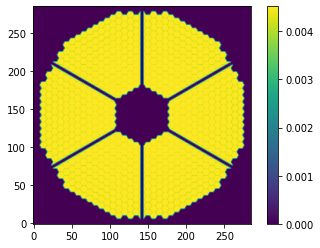

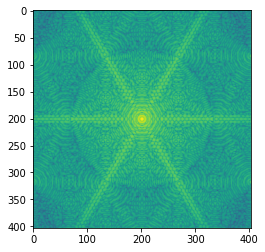

In [3]:
get_throughput('ELT-L');

ELT: fwhm=8.52pix, aper_flux=0.3687, (cx,cy)=(162.0,162.0)


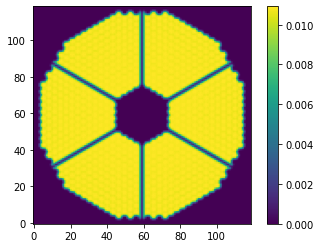

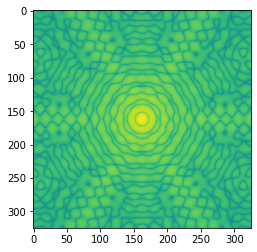

In [4]:
get_throughput('ELT-N');

# Standard IMG

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6894
Total throughput = 0.6894


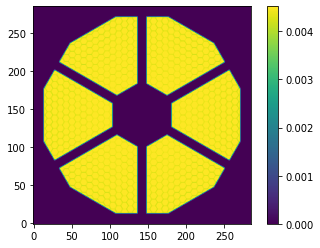

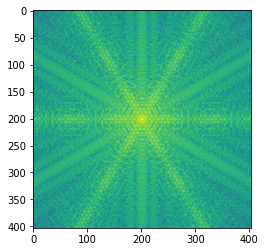

In [5]:
get_throughput('IMG-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.7137
Total throughput = 0.7137


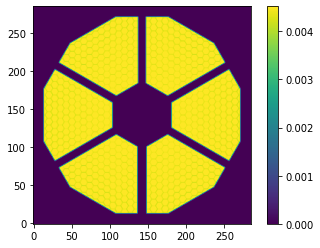

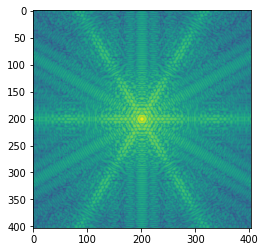

In [6]:
get_throughput('IMG-LM-thick', dRspi_thick=0.0291, AP_angles=[0]);#, show_pup=False);

ELT: fwhm=8.52pix, aper_flux=0.3687, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.6352
Total throughput = 0.6352


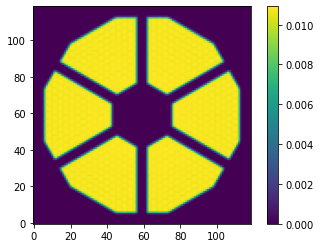

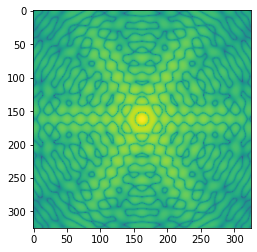

In [7]:
get_throughput('IMG-N');

ELT: fwhm=8.52pix, aper_flux=0.3687, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.6583
Total throughput = 0.6583


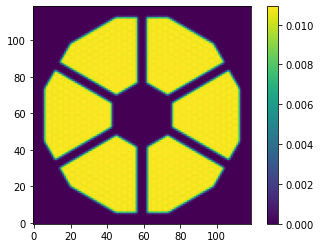

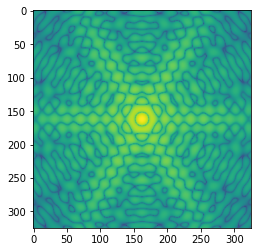

In [8]:
get_throughput('IMG-N-thick', dRspi_thick=0.0357, AP_angles=[0]);#, show_pup=False);

# LM modes

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.1936
APP transmittance = 0.7334
Total throughput = 0.1420


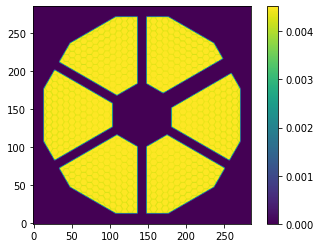

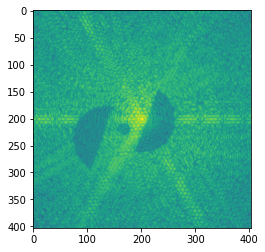

In [9]:
get_throughput('APP-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.2272
SPP transmittance = 0.9200
Total throughput = 0.2090


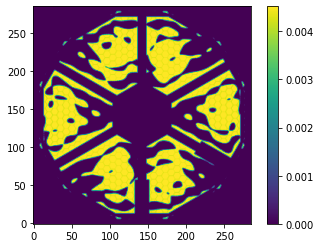

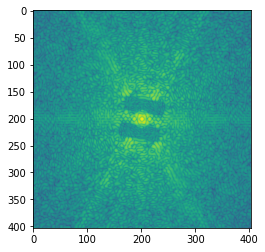

In [10]:
get_throughput('SPP-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.2091
VPM transmittance = 0.8532
OAT @ 5 lambda/D = 0.8829
Total throughput = 0.1575


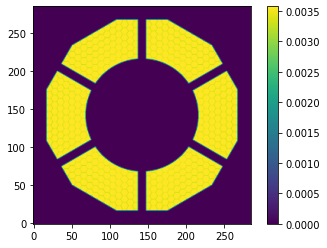

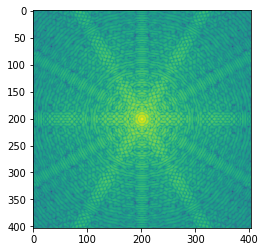

In [11]:
get_throughput('RLS-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6330
VPM transmittance = 0.8532
OAT @ 5 lambda/D = 0.8188
Total throughput = 0.4422


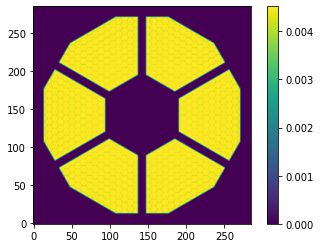

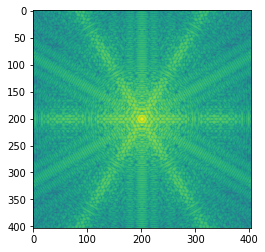

In [12]:
get_throughput('CLS-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.4219
Total throughput = 0.4219


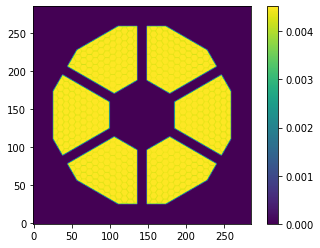

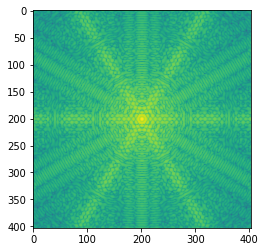

In [13]:
get_throughput('ULS-LM');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.2011
APP transmittance = 0.7334
Total throughput = 0.1475


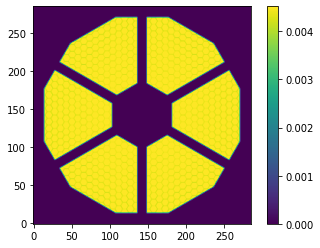

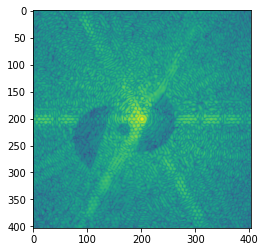

In [14]:
get_throughput('APP-LMS');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.2063
VPM transmittance = 0.8532
OAT @ 5 lambda/D = 0.8828
Total throughput = 0.1554


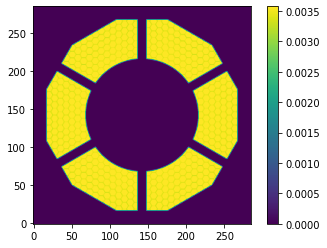

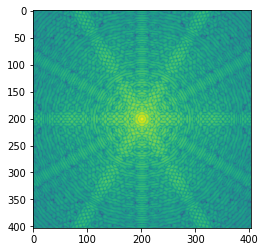

In [15]:
get_throughput('RLS-LMS');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6127
VPM transmittance = 0.8532
OAT @ 5 lambda/D = 0.8190
Total throughput = 0.4281


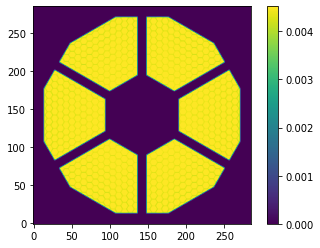

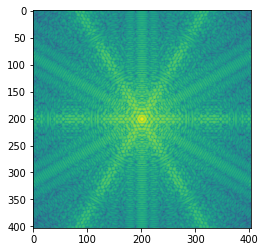

In [16]:
get_throughput('CLS-LMS');

ELT: fwhm=3.51pix, aper_flux=0.3513, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.4219
Total throughput = 0.4219


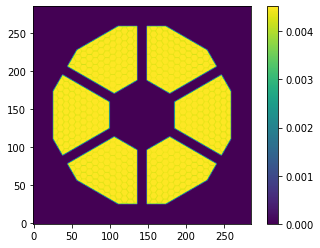

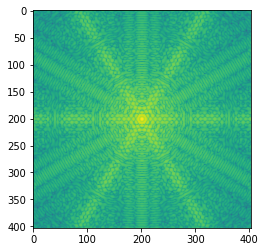

In [17]:
get_throughput('ULS-LMS'); # same as ULC-LM

# N modes

ELT: fwhm=8.52pix, aper_flux=0.3687, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.5728
VPM transmittance = 0.9291
OAT @ 5 lambda/D = 0.8332
Total throughput = 0.4434


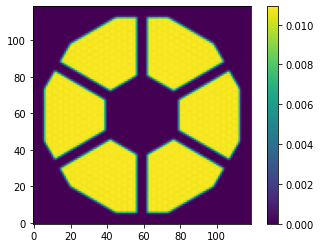

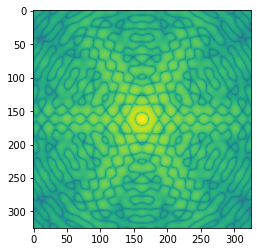

In [18]:
get_throughput('CLS-N');

ELT: fwhm=8.52pix, aper_flux=0.3687, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.4111
Total throughput = 0.4111


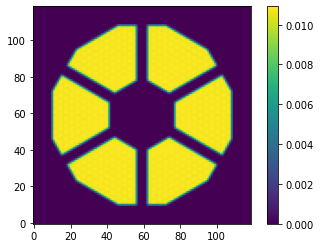

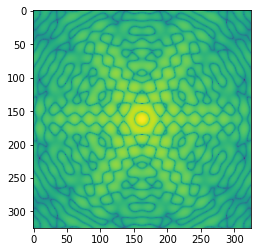

In [19]:
get_throughput('ULS-N');